In [1]:
import numpy as np
import pandas as pd

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set(rc={"figure.figsize":(9,6)})

In [4]:
events_data = pd.read_csv('event_data_train.csv')
submissions_data = pd.read_csv('submissions_data_train.csv')

In [5]:
events_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [6]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [7]:
events_data.action.unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

In [8]:
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')

In [9]:
submissions_data['date']= pd.to_datetime(submissions_data.timestamp, unit='s')

In [10]:
events_data["day"] = events_data.date.dt.date

In [11]:
submissions_data["day"] = submissions_data.date.dt.date

In [12]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


<Axes: xlabel='day'>

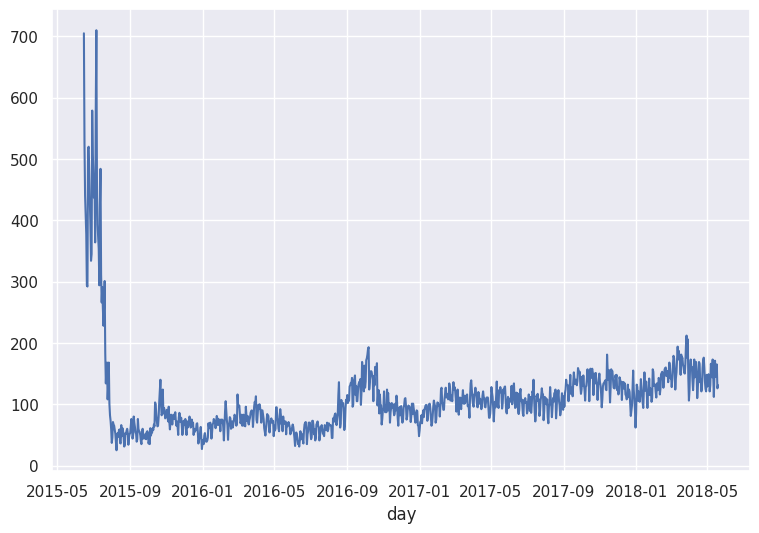

In [13]:
events_data.groupby("day")\
    .user_id.nunique().plot()

<Axes: >

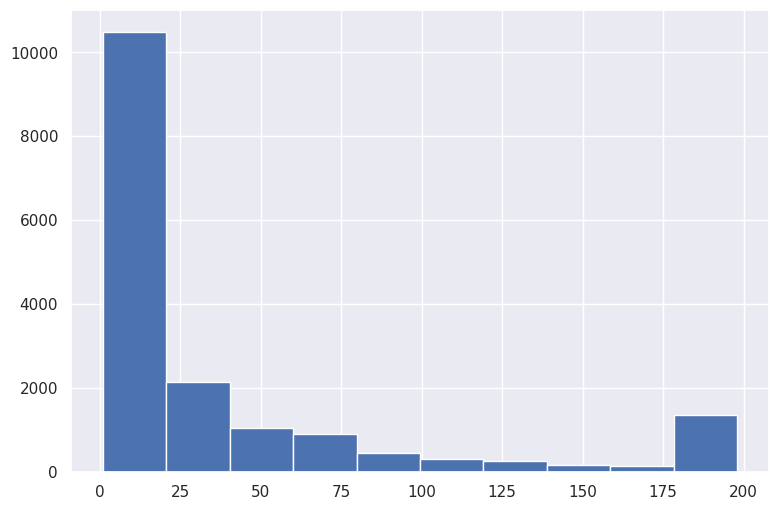

In [14]:
events_data[events_data.action == 'passed'] \
    .groupby("user_id", as_index=False)\
    .agg({"step_id" : "count"})\
    .rename(columns={"step_id":"passed_steps"}).passed_steps.hist()
#Bad solution

In [15]:
events_data[events_data.action == 'passed'] \
    .groupby("user_id", as_index=False)\
    .agg({"step_id" : "count"})\
    .rename(columns={"step_id":"passed_steps"}).passed_steps.min()

1

In [16]:
users_events_data = events_data.pivot_table(index = "user_id",
                        columns = "action",
                        values = "step_id",
                        aggfunc="count",
                       fill_value=0).reset_index()

In [17]:
users_events_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


In [18]:
users_scores = submissions_data.pivot_table(index = "user_id",
                        columns = "submission_status",
                        values = "step_id",
                        aggfunc="count",
                       fill_value=0).reset_index()

In [19]:
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [20]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [21]:
gap_data = events_data[['user_id','day','timestamp']].drop_duplicates(subset=['user_id','day'])\
    .groupby("user_id")['timestamp'].apply(list)\
    .apply(np.diff).values

In [22]:
gap_data = pd.Series(np.concatenate(gap_data, axis=0))

In [23]:
gap_data = gap_data/(24*60*60)

<Axes: >

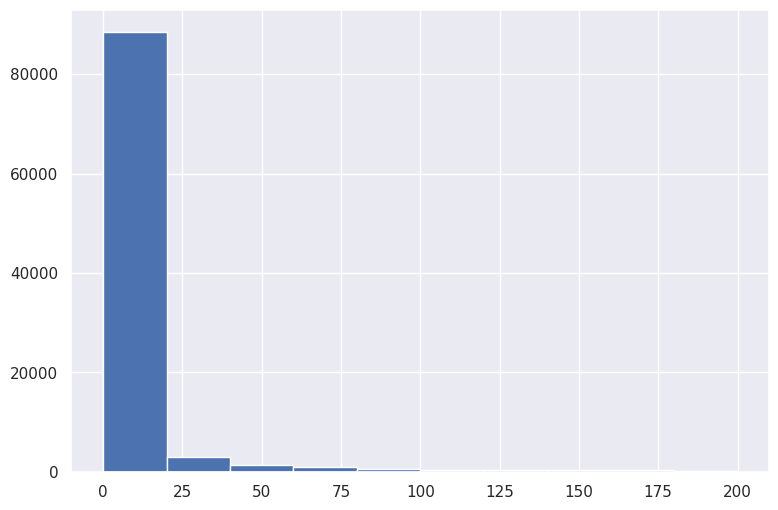

In [24]:
gap_data[gap_data < 200].hist()

In [25]:
gap_data.quantile(0.95)

59.760440972222156

In [26]:
events_data.tail()

,step_id,timestamp,action,user_id,date,day
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19
3480702,33892,1526772811,viewed,18526,2018-05-19 23:33:31,2018-05-19


In [27]:
users_data = events_data.groupby('user_id',as_index=False)\
    .agg({'timestamp' : 'max'}).rename(columns = {"timestamp":"last_timestamp"})

In [28]:
now = 1526772811
drop_out_treshold = 2592000

In [29]:
users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out_treshold

In [30]:
users_data.head()

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


In [31]:
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [32]:
users_data = users_data.merge(users_scores,on='user_id',how='outer')

In [33]:
users_data = users_data.fillna(0)

In [34]:
users_data = users_data.merge(users_events_data,how='outer')

In [35]:
users_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()

In [36]:
users_days.head()

,user_id,day
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1


In [37]:
users_data = users_data.merge(users_days,how='outer')

In [38]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1


In [39]:
users_data.user_id.nunique()

19234

In [40]:
users_data["passed_corse"] = users_data.passed > 170

In [41]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_corse
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


In [42]:
users_data.groupby('passed_corse').count()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
passed_corse,,,,,,,,,,
False,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809
True,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425


In [43]:
1425/17809 * 100

8.001572238755687

<Axes: >

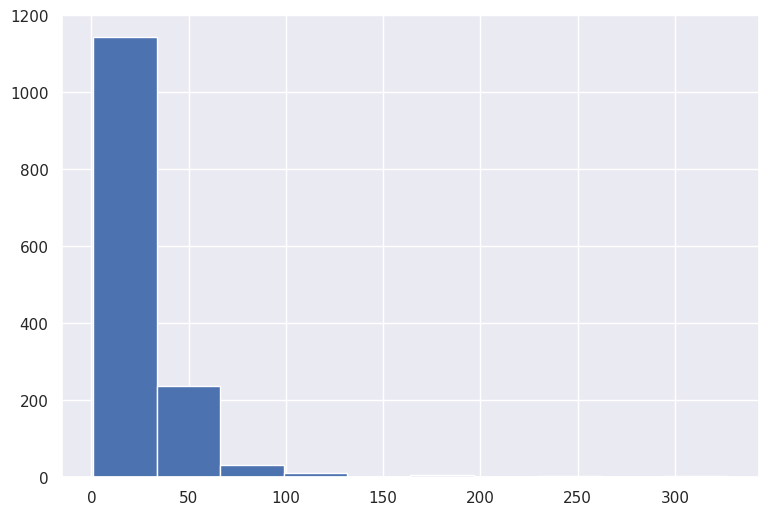

In [44]:
users_data[users_data.passed_corse].day.hist()

In [45]:
user_min_time = events_data.groupby('user_id', as_index=False)\
    .agg({'timestamp':'min'})\
    .rename({'timestamp':'min_timestamp'},axis=1)

In [46]:
user_min_time.head()

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660


In [47]:
users_data = users_data.merge(user_min_time, how='outer')

In [48]:
events_data_train = pd.DataFrame()

## Bad solution

In [49]:
## Too long

# for user_id in users_data.user_id:
#     min_user_time = users_data[users_data.user_id == user_id].min_timestamp.item()
#     time_threshold = min_user_time + 3 * 24 * 60 * 60
    
#     users_events_data = events_data[(events_data.user_id==user_id)&(events_data.timestamp < time_threshold)]
    
#     events_data_train = events_data_train.append(user_events_data)


## Good solution

In [50]:
#events_data_train = events_data[]

In [51]:
events_data['user_time'] = events_data.user_id.map(str)+'_'+events_data.timestamp.map(str)

In [52]:
events_data.head()

,step_id,timestamp,action,user_id,date,day,user_time
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895


In [53]:
learning_time_threshold = 3 * 24 * 60 * 60
learning_time_threshold

259200

In [54]:
user_min_time.head()

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660


In [55]:
user_learning_time_threshold = user_min_time.user_id.map(str)+'_'+(user_min_time.min_timestamp + learning_time_threshold).map(str)

In [56]:
user_learning_time_threshold.head()

0    1_1473086664
1    2_1514642564
2    3_1434617676
3    5_1466416009
4    7_1521893860
dtype: object

In [57]:
user_min_time['user_learning_time_threshold'] = user_learning_time_threshold

In [58]:
events_data = events_data.merge(user_min_time[['user_id','user_learning_time_threshold']], how='outer')

In [59]:
events_data.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,31981,1472827464,viewed,1,2016-09-02 14:44:24,2016-09-02,1_1472827464,1_1473086664
1,31981,1472827464,discovered,1,2016-09-02 14:44:24,2016-09-02,1_1472827464,1_1473086664
2,32815,1514383364,discovered,2,2017-12-27 14:02:44,2017-12-27,2_1514383364,2_1514642564
3,32815,1514383364,viewed,2,2017-12-27 14:02:44,2017-12-27,2_1514383364,2_1514642564
4,32815,1514383364,passed,2,2017-12-27 14:02:44,2017-12-27,2_1514383364,2_1514642564


In [60]:
events_data_train = events_data[events_data.user_time <= events_data.user_learning_time_threshold]

In [61]:
events_data_train.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,31981,1472827464,viewed,1,2016-09-02 14:44:24,2016-09-02,1_1472827464,1_1473086664
1,31981,1472827464,discovered,1,2016-09-02 14:44:24,2016-09-02,1_1472827464,1_1473086664
2,32815,1514383364,discovered,2,2017-12-27 14:02:44,2017-12-27,2_1514383364,2_1514642564
3,32815,1514383364,viewed,2,2017-12-27 14:02:44,2017-12-27,2_1514383364,2_1514642564
4,32815,1514383364,passed,2,2017-12-27 14:02:44,2017-12-27,2_1514383364,2_1514642564


In [62]:
events_data_train.groupby('user_id').day.nunique().max()

4

In [63]:
submissions_data['user_time'] = submissions_data.user_id.map(str)+'_'+submissions_data.timestamp.map(str)
submissions_data = submissions_data.merge(user_min_time[['user_id','user_learning_time_threshold']],how = 'outer')
submissions_data_train = submissions_data[submissions_data.user_time <= submissions_data.user_learning_time_threshold]
submissions_data_train.groupby('user_id').day.nunique().max()

4

In [64]:
X = submissions_data_train.groupby('user_id').day.nunique().to_frame().reset_index()\
    .rename(columns = {'day':'days'})

In [65]:
steps_tried = submissions_data_train.groupby('user_id').step_id.nunique().to_frame().reset_index()\
    .rename(columns = {'step_id':'steps_tried'})

In [66]:
X = X.merge(steps_tried, on='user_id',how='outer')

In [67]:
X.head()

,user_id,days,steps_tried
0,2,1,2
1,3,1,4
2,8,1,11
3,14,1,1
4,16,3,23


In [68]:
X = X.merge(submissions_data_train.pivot_table(
    index='user_id',
    columns='submission_status',
    values = 'step_id',
    aggfunc = 'count',
    fill_value = 0
).reset_index())

In [69]:
X['correct_ratio'] = X.correct / (X.correct+X.wrong)

In [70]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio
0,2,1,2,2,0,1.00
1,3,1,4,4,4,0.50
2,8,1,11,9,21,0.30
3,14,1,1,0,1,0.00
4,16,3,23,23,27,0.46


In [71]:
X = X.merge(events_data_train.pivot_table(
    index = 'user_id',
    columns='action',
    values='step_id',
    aggfunc='count',
    fill_value = 0
).reset_index()[['user_id','viewed']],how='outer')

In [72]:
X = X.fillna(0)

In [73]:
X = X.merge(users_data[['user_id','passed_corse','is_gone_user']],how='outer')

In [74]:
X = X[~((X.is_gone_user == False) & (X.passed_corse == False))]

In [75]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_corse,is_gone_user
0,1,0.0,0.0,0.0,0.0,0.0,1,False,True
1,2,1.0,2.0,2.0,0.0,1.0,9,False,True
2,3,1.0,4.0,4.0,4.0,0.5,20,False,True
3,5,0.0,0.0,0.0,0.0,0.0,1,False,True
4,7,0.0,0.0,0.0,0.0,0.0,1,False,True


In [76]:
X.groupby(['passed_corse','is_gone_user']).user_id.count()

passed_corse  is_gone_user
False         True            16560
True          False             141
              True             1284
Name: user_id, dtype: int64

In [77]:
y = X[X.steps_tried>0][["user_id","passed_corse"]]

In [78]:
y = y.map(int)

In [79]:
y = y.set_index(y.user_id)
y = y.drop("user_id",axis=1)
y.head()

,passed_corse
user_id,
2,0
3,0
8,0
14,0
16,1


In [80]:
X = X.drop(['passed_corse','is_gone_user'],axis=1)

In [81]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed
0,1,0.0,0.0,0.0,0.0,0.0,1
1,2,1.0,2.0,2.0,0.0,1.0,9
2,3,1.0,4.0,4.0,4.0,0.5,20
3,5,0.0,0.0,0.0,0.0,0.0,1
4,7,0.0,0.0,0.0,0.0,0.0,1


In [82]:
X=X.set_index(X.user_id)
X = X.drop('user_id',axis=1)

In [83]:
X = X[X.steps_tried>0]

In [84]:
list(X)

['days', 'steps_tried', 'correct', 'wrong', 'correct_ratio', 'viewed']

In [85]:
print(len(X))
X.tail()

8254


,days,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
26787,1.0,3.0,3.0,0.0,1.000000,14
26790,1.0,1.0,1.0,0.0,1.000000,6
26794,3.0,27.0,31.0,9.0,0.775000,134
26797,1.0,2.0,2.0,0.0,1.000000,10
26798,1.0,2.0,2.0,1.0,0.666667,12


In [86]:
print(len(y))
y.tail()

8254


,passed_corse
user_id,
26787,0
26790,0
26794,0
26797,0
26798,0


In [87]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import metrics

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle=True,test_size=0.2, random_state = 41)

In [95]:
from sklearn.linear_model import LogisticRegression
log_params = {
    "penalty" : ["l1","l2","elasticnet"],
    "dual":[True, False],
    "fit_intercept": [True, False],
    "class_weight" : [None,"balanced"]
}
lin = LogisticRegression(max_iter=500,solver = "newton-cholesky")
search = GridSearchCV(estimator=lin,cv=5,param_grid=log_params,verbose=1)
search.fit(X_train,y_train.values.ravel())
lin = search.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/home/vadimpp/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
100 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/home/vadimpp/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vadimpp/.local/lib/python3.12/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/vadimpp/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py", li

In [96]:
lin

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,False
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'newton-cholesky'
,max_iter,500
,multi_class,'deprecated'


In [97]:
lin_pred = lin.predict(X_test)

In [98]:
print("ROC-AUC: ", metrics.roc_auc_score(lin_pred,y_test))

ROC-AUC:  0.7108796099139767


In [99]:
print(metrics.classification_report(lin_pred,y_test))

              precision    recall  f1-score   support

           0       0.98      0.86      0.92      1592
           1       0.13      0.56      0.21        59

    accuracy                           0.85      1651
   macro avg       0.56      0.71      0.57      1651
weighted avg       0.95      0.85      0.89      1651



In [100]:
from sklearn.tree import DecisionTreeClassifier

params = {
    "max_depth" : range(2,len(X_train.columns)),
    "min_samples_leaf" : range(10,100,10),
    "min_samples_split" : range(10,100,10),
}

tree = DecisionTreeClassifier()
search = GridSearchCV(estimator=tree,cv=5,param_grid=params,verbose=1)
search.fit(X_train,y_train.values.ravel())
tree_model = search.best_estimator_

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


In [101]:
tree_model

,criterion,'gini'
,splitter,'best'
,max_depth,5
,min_samples_split,10
,min_samples_leaf,40
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [102]:
tree_pred = tree_model.predict(X_test)

In [103]:
print("ROC-AUC: ", metrics.roc_auc_score(tree_pred,y_test))

ROC-AUC:  0.7181779619538617


In [105]:
print(metrics.classification_report(tree_pred,y_test))

              precision    recall  f1-score   support

           0       0.99      0.86      0.92      1613
           1       0.09      0.58      0.15        38

    accuracy                           0.85      1651
   macro avg       0.54      0.72      0.54      1651
weighted avg       0.97      0.85      0.90      1651



In [145]:
from sklearn.ensemble import RandomForestClassifier

rfc_search_space = {
    'n_estimators': range(10, 101),
    'criterion': ['gini', 'entropy'],
    'max_depth': range(2, 51),
    'min_samples_split': range(2, 11),
    'min_samples_leaf': range(1, 11),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

rfc = RandomForestClassifier()
random_search = RandomizedSearchCV(estimator=rfc, param_distributions=rfc_search_space, n_iter=200, cv=5,verbose=0)
random_search.fit(X_train, y_train.values.ravel())
forest_model = random_search.best_estimator_

In [146]:
forest_model

,n_estimators,55
,criterion,'gini'
,max_depth,7
,min_samples_split,10
,min_samples_leaf,10
,min_weight_fraction_leaf,0.0
,max_features,'log2'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,False
,oob_score,False


In [147]:
fst_pred = forest_model.predict(X_test)

In [148]:
print("ROC-AUC: ", metrics.roc_auc_score(fst_pred,y_test))

ROC-AUC:  0.7238420181968569


In [149]:
print(metrics.classification_report(fst_pred,y_test))

              precision    recall  f1-score   support

           0       0.99      0.86      0.92      1612
           1       0.09      0.59      0.16        39

    accuracy                           0.85      1651
   macro avg       0.54      0.72      0.54      1651
weighted avg       0.97      0.85      0.90      1651



In [141]:
from sklearn.svm import LinearSVC

svc_model = LinearSVC(max_iter=2000,tol=1e-5, penalty ="l2",C=1)
svc_model.fit(X_train, y_train.values.ravel())

,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,1e-05
,C,1
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,verbose,0
,random_state,None


In [142]:
svc_pred = svc_model.predict(X_test)

In [143]:
print("ROC-AUC: ", metrics.roc_auc_score(svc_pred,y_test))

ROC-AUC:  0.7352328705776981


In [144]:
print(metrics.classification_report(svc_pred,y_test))

              precision    recall  f1-score   support

           0       0.98      0.86      0.92      1595
           1       0.13      0.61      0.22        56

    accuracy                           0.85      1651
   macro avg       0.56      0.74      0.57      1651
weighted avg       0.96      0.85      0.90      1651

